# Корреляционный анализ

## Библиотеки

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import scipy.stats as st
import seaborn as sns

import statsmodels.api as sm

## Warmup

### Задача

Рассмотрим задачу нахождения корреляции Пирсона для двух случайных величин:

$X_1 \sim \mathcal{N}(0,1), \qquad X_2 = X_1 + \alpha\varepsilon, \quad \varepsilon \sim\mathcal{N}(0,1)$

Какова их корреляция?

### Данные

In [3]:
n = 10

alpha = 0.5
mean1 = mean2 = 0
disp1 = 1
disp2 = 1 + alpha**2
corr = 1.0/np.sqrt(disp2)

print(corr, disp2)

0.8944271909999159 1.25


### Проверка гипотезы о независимости

In [6]:
noises = np.arange(0.5, 10.0, 0.5)

for noise in noises:    
    results_t = []
    results_z = []
    corr = 1.0/np.sqrt(1+noise**2)
    for _ in range(1000):
        data1 = np.random.randn(n)
        data2 = data1 + noise*np.random.randn(n)
        
        pearson = st.pearsonr(data1, data2)[0]
        if pearson == 1.:
            pearson = 0.99999
        
        # Критерий Стьюдента
        T = pearson * np.sqrt(n-2)/np.sqrt(1 - pearson**2)
        t_pval = 2 *(1 - st.distributions.t(n-2).cdf(abs(T)))

        # Преобразование Фишера
        Z = np.arctanh(pearson)*np.sqrt(n-3)
        z_pval = 2*(1 - st.distributions.norm.cdf(abs(Z)))

        t_res = t_pval>=0.05
        z_res = z_pval>=0.05
        results_t.append(t_res)
        results_z.append(z_res)
        
    print(noise, ':', corr, np.mean(results_t), np.mean(results_z))

0.5 : 0.8944271909999159 0.027 0.025
1.0 : 0.7071067811865475 0.289 0.285
1.5 : 0.5547001962252291 0.577 0.572
2.0 : 0.4472135954999579 0.751 0.748
2.5 : 0.3713906763541037 0.818 0.813
3.0 : 0.31622776601683794 0.863 0.861
3.5 : 0.27472112789737807 0.881 0.877
4.0 : 0.24253562503633297 0.899 0.899
4.5 : 0.21693045781865616 0.906 0.905
5.0 : 0.19611613513818404 0.908 0.905
5.5 : 0.17888543819998318 0.92 0.918
6.0 : 0.1643989873053573 0.93 0.93
6.5 : 0.1520571842539411 0.94 0.939
7.0 : 0.1414213562373095 0.928 0.924
7.5 : 0.13216372009101796 0.931 0.929
8.0 : 0.12403473458920847 0.951 0.949
8.5 : 0.1168412475673972 0.926 0.925
9.0 : 0.11043152607484653 0.938 0.938
9.5 : 0.10468478451804275 0.943 0.941


### Добавление выброса

In [4]:
n = 100*1000
alpha = 0.2
data1 = np.random.randn(n)
data2 = data1 + alpha*np.random.randn(n)
mean1 = mean2 = 0
disp1 = 1
disp2 = 1+alpha**2
corr = 1.0/np.sqrt(disp2)
corr

0.9805806756909201

In [5]:
data1_new = data1.copy()
data2_new = data2.copy()
data1_new[0] += 9999

In [6]:
# Один единственный элемент с выборосом существенно меняется коэффициент корреляции Пирсона
st.pearsonr(data1, data2)[0], st.pearsonr(data1_new, data2_new)[0]

(0.9804284027412512, 0.03261933171652169)

In [7]:
# В случае корреляции Спирмана удается избежать подобной ошибки
st.spearmanr(data1, data2)[0], st.spearmanr(data1_new, data2_new)[0]

(0.978429204289735, 0.9784242464780705)

In [8]:
# Аналогично про корреляцию Кендалла
# Точнее оценивается по выборке небольших объемов
st.kendalltau(data1, data2)[0], st.kendalltau(data1_new, data2_new)[0]

(0.8738200234002341, 0.8738104557045573)

### Корреляция рангов

In [9]:
data = [6, 1, 5, 4, 3, 2]
st.rankdata(data)

array([6., 1., 5., 4., 3., 2.])

In [10]:
# Ранги при помощи argsort
np.argsort(np.argsort(data)) + 1

array([6, 1, 5, 4, 3, 2])

In [11]:
ranks1 = st.rankdata(data1)
ranks2 = st.rankdata(data2)

st.pearsonr(ranks1, ranks2)

(0.9784292042897349, 0.0)

## Успеваемость первокурсников

Для 600 первокурсников известны показатели успеваемости по четырём предметам и результаты трёх психологических тестов. Как связаны эти два набора переменных?



In [12]:
data = pd.read_csv('./data/mmreg.csv')

In [13]:
data.sample(5)

,locus_of_control,self_concept,motivation,read,write,math,science
288,-0.65,0.03,0.33,41.6,39.1,42.3,41.7
511,0.25,-0.47,0.33,76.0,67.1,72.2,66.1
382,0.66,-0.47,0.67,54.8,59.3,50.6,60.7
531,-0.60,0.90,0.67,46.9,61.9,45.4,33.6
349,0.48,0.32,1.00,49.5,54.1,38.7,49.8


In [14]:
psych = data.loc[:, data.columns[:3]]
psych.head()

,locus_of_control,self_concept,motivation
0,-0.84,-0.24,1.00
1,-0.38,-0.47,0.67
2,0.89,0.59,0.67
3,0.71,0.28,0.67
4,-0.64,0.03,1.00


In [15]:
acad = data.loc[:, data.columns[3:]]
acad.head()

,read,write,math,science
0,54.8,64.5,44.5,52.6
1,62.7,43.7,44.7,52.6
2,60.6,56.7,70.5,58.0
3,62.7,56.7,54.7,58.0
4,41.6,46.3,38.4,36.3


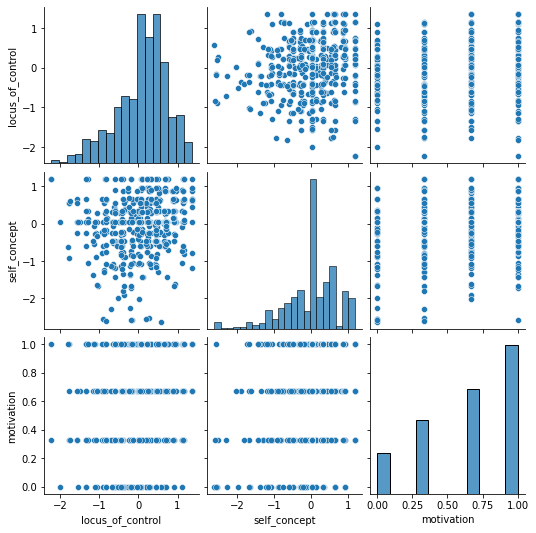

In [16]:
_ = sns.pairplot(psych)

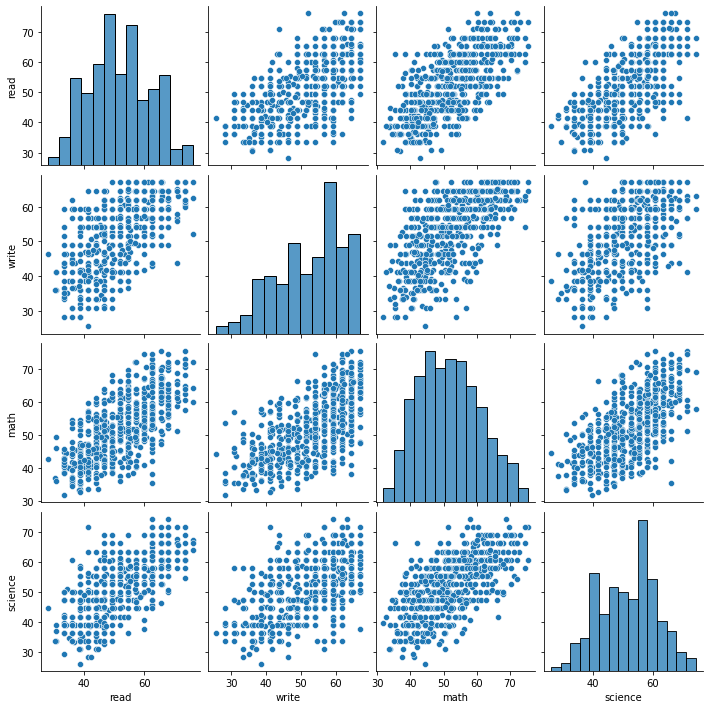

In [17]:
_ = sns.pairplot(acad)

### Попарные корреляции Пирсона:

In [18]:
np.corrcoef(acad.values.T)

array([[1.        , 0.62859089, 0.67927568, 0.69069291],
       [0.62859089, 1.        , 0.6326664 , 0.56914983],
       [0.67927568, 0.6326664 , 1.        , 0.64952612],
       [0.69069291, 0.56914983, 0.64952612, 1.        ]])

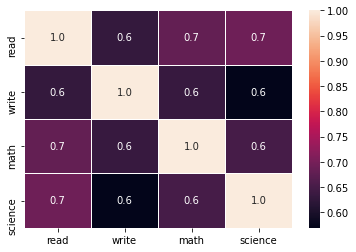

In [21]:
_ = sns.heatmap(acad.corr(), annot= True, linewidths=0.5, fmt = ".1f")

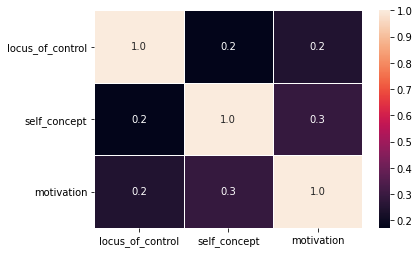

In [22]:
_ = sns.heatmap(psych.corr(), annot= True, linewidths=0.5, fmt = ".1f")

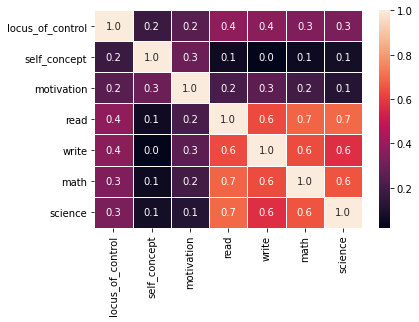

In [23]:
_ = sns.heatmap(data.corr(),annot= True,linewidths=0.5,fmt = ".1f")

### Рассмотрим различные виды корреляций и их p-value:

In [55]:
print("Pearson:")
for i in range(3):
    for j in range(3,7):
        print(data.columns[i], data.columns[j], ": p-value =", np.round(st.pearsonr(data.loc[:, data.columns[i]], data.loc[:, data.columns[j]])[1], 3))

print("\nSpearman:")
for i in range(3):
    for j in range(3,7):
        print(data.columns[i], data.columns[j], ": p-value =", tuple(np.round(st.spearmanr(data.loc[:, data.columns[i]], data.loc[:, data.columns[j]]), 3))[1])
        
print("\nKendall:")
for i in range(3):
    for j in range(3,7):
        print(data.columns[i], data.columns[j], ": p-value =", tuple(np.round(st.kendalltau(data.loc[:, data.columns[i]], data.loc[:, data.columns[j]]), 3))[1])
        

Pearson:
locus_of_control read : p-value = 0.0
locus_of_control write : p-value = 0.0
locus_of_control math : p-value = 0.0
locus_of_control science : p-value = 0.0
self_concept read : p-value = 0.138
self_concept write : p-value = 0.634
self_concept math : p-value = 0.19
self_concept science : p-value = 0.087
motivation read : p-value = 0.0
motivation write : p-value = 0.0
motivation math : p-value = 0.0
motivation science : p-value = 0.005

Spearman:
locus_of_control read : p-value = 0.0
locus_of_control write : p-value = 0.0
locus_of_control math : p-value = 0.0
locus_of_control science : p-value = 0.0
self_concept read : p-value = 0.149
self_concept write : p-value = 0.981
self_concept math : p-value = 0.195
self_concept science : p-value = 0.076
motivation read : p-value = 0.0
motivation write : p-value = 0.0
motivation math : p-value = 0.0
motivation science : p-value = 0.002

Kendall:
locus_of_control read : p-value = 0.0
locus_of_control write : p-value = 0.0
locus_of_control m

$p-value > 0.05 \rightarrow$ данные не противоречат гипотезе о независимости переменных

## Образование и вера
**2008 General Social Survey, National Opinion Research center (Agresti A. Categorical Data Analysis. — Hoboken: John Wiley & Sons, 2013, табл. 3.2)**

General Social Survey — ежегодный опрос населения США, записывается около 5000 факторов. Из опроса 2008 года выбраны данные о вере и образовании 2000 опрошенных. Есть ли связь между степенью веры и уровнем образования?

In [56]:
data= pd.read_csv('./data/fe.txt', delimiter='\t')

In [57]:
data.head()

,Highest degree,don’t believe,no way to find out,some higher power,believe sometimes,believe but doubts,know God exists
0,Less than high school,9,8,27,8,47,236
1,High school or junior college,23,39,88,49,179,706
2,Bachelor or graduate,28,48,89,19,104,293


### Pearson $\chi^2$

Условия применимости:
 - $n \geq 40$

In [58]:
values = data.values[:, 1:].astype(np.float)
values

array([[  9.,   8.,  27.,   8.,  47., 236.],
       [ 23.,  39.,  88.,  49., 179., 706.],
       [ 28.,  48.,  89.,  19., 104., 293.]])

In [75]:
# Насколько коррелируют данные по строкам
st.chi2_contingency(values)[1]

2.842572791195739e-12

Критерий применялся к строкам выборки $\rightarrow$ есть нулевая гипотеза о независимости строк отвергается $\rightarrow$ не может сказать, что обучение как-то влияет на веру

### G-test

In [76]:
st.chi2_contingency(values, lambda_ = "log-likelihood")[1]

1.0705703476205307e-11

Аналогично для $G-test$

### Коэффициент V-Крамера

Сделали так, потому что распредление категориальное (6 дискретных распределений)

In [53]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = st.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    r,k = confusion_matrix.shape
    return np.sqrt(chi2/(n*min(r, k) - n))

In [54]:
stat = cramers_corrected_stat(values)
stat

0.1379749308441694

### Корреляция между порядковыми переменными

In [77]:
pc = 0
pd = 0
pt = 0

for i in range(3):
    for j in range(6):
        for k in range(3):
            for z in range(6):
                current = values[i, j]*values[k, z]
                n+=current
                if i==k or j == z:
                    pt += current
                elif i>k and j>z:
                    pc += current
                else:
                    pd += current
gamma = (pc - pd) / (pc + pt)
# n^2 = pc + pd + pt
print(gamma)

-0.30233140596713687


### Встречаемость через длину

In [61]:
new_data = []
for i in range(values.shape[0]):
    for j in range(values.shape[1]):
        new_data.extend([[i,j]]*int(values[i,j]))
new_data = np.array(new_data)
new_data.shape

(2000, 2)

In [62]:
st.pearsonr(new_data[:,0], new_data[:, 1])[0]

-0.1620375916236811

In [63]:
st.kendalltau(new_data[:,0], new_data[:,1])[0]

-0.1475371344671059

In [64]:
st.spearmanr(new_data[:,0], new_data[:,1])[0]

-0.16436204271249027

In [65]:
data.values

array([['Less than high school', 9, 8, 27, 8, 47, 236],
       ['High school or junior college', 23, 39, 88, 49, 179, 706],
       ['Bachelor or graduate', 28, 48, 89, 19, 104, 293]], dtype=object)

### Через statmodels

In [66]:
table = sm.stats.Table(data.values[:, 1:])

In [67]:
table.table_orig

array([[9, 8, 27, 8, 47, 236],
       [23, 39, 88, 49, 179, 706],
       [28, 48, 89, 19, 104, 293]], dtype=object)

In [68]:
chi2_test = table.test_nominal_association()

In [69]:
chi2_test.statistic

76.14832616581332

In [70]:
chi2_test.pvalue

2.842615032250251e-12

### Корреляция Мэтьюся

Поиск коэффициента корреляции между двумя бинарными переменными

$$MCC = \frac{ad-bc}{\sqrt{(a+b)(a+c)(b+d)(c+d)}}$$

In [68]:
for i in range(1, 3):
    print('#'*30)
    print (data.values[i, 0])
    for j in range(1, 6):
        a = values[i:, j:].sum()
        b = values[i:, :j].sum()
        c = values[:i, j:].sum()
        d = values[:i, :j].sum()
        C = (a*d - b*c)/((a+b)*(a+c)*(b+c)*(c+d))**0.5

        
        print('{}: {}'.format(data.columns[j+1], C))



##############################
High school or junior college
no way to find out: -0.0032878972142129214
some higher power: -0.026166704823330604
believe sometimes: -0.04332230388469834
believe but doubts: -0.05472333256702768
know God exists: -0.07392920094188866
##############################
Bachelor or graduate
no way to find out: -0.014052274802607664
some higher power: -0.042208233986054826
believe sometimes: -0.08854271827202974
believe but doubts: -0.08727154689593274
know God exists: -0.11753738675740537


## IE vs Murders Rate

**Disclaimer: пример выдуман, данных нет. Для наглядности.**

In [74]:
_ = plt.xkcd()

### Вариант 1
Пусть число убийств и процент пользователей Internet Explorer линейно зависят от года:

In [79]:
rs = np.random.RandomState(0)
years = np.arange(2006, 2012)
ie_users = -0.075 *  years + 151.25 + rs.uniform(size=years.shape[0])*0.1
ie_users

array([0.85488135, 0.79651894, 0.71027634, 0.62948832, 0.54236548,
       0.48958941])

In [80]:
rs = np.random.RandomState(0)
murder_num = -0.075 *  years + 151. + rs.uniform(size=years.shape[0])*0.1
murder_num

array([0.60488135, 0.54651894, 0.46027634, 0.37948832, 0.29236548,
       0.23958941])

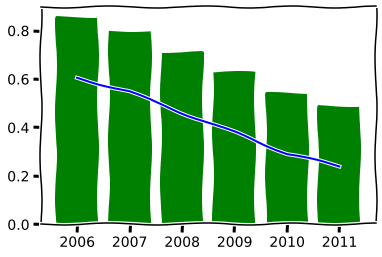

In [81]:
plt.bar(years, ie_users, color='g')
plt.plot(years, murder_num, c='b')

_ = plt.show()

In [82]:
# Попарная корреляция Пирсона между всеми величинами

r12 = st.pearsonr(ie_users, murder_num)[0]
r13 = st.pearsonr(ie_users, years)[0]
r23 = st.pearsonr(murder_num, years)[0]

r12, r13, r23

(0.9999999999999999, -0.9977033457324236, -0.9977033457324236)

#### Условная корреляция
$$r_{1,2|3} = \frac{r_{1, 2} - r_{1, 3}*r_{2, 3}}{\sqrt[]{(1-r_{1, 3}^2)(1-r_{2, 3}^2)}}$$


In [83]:
r = (r12 - r13*r23) / np.sqrt((1-r13**2)*(1-r23**2))
r

1.0

Следовательно, они все зависимы.

### Вариант 2
Оба показателя линейно зависят от числа компьютеров в мире.
Число компьютеров зависит от года.

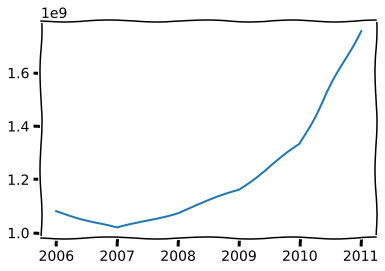

In [83]:
rs = np.random.RandomState(0)
comp_num = 10**9+np.exp(years-2006)*0.5*10**7 + rs.randint(low=0, high=10**8, size=years.shape[0])

plt.plot(years, comp_num)
plt.show()

In [84]:
rs = np.random.RandomState(0)
ie_users =   -0.6/10**9 *  comp_num+1.4 + rs.uniform(size=years.shape[0])*0.1
ie_users 


array([0.80662055, 0.86203503, 0.81488189, 0.75764987, 0.6434386 ,
       0.41032603])

In [85]:
rs = np.random.RandomState(0)
murder_num =  -0.6/10**9 *  comp_num+1.15 + rs.uniform(size=years.shape[0])*0.1
murder_num

array([0.55662055, 0.61203503, 0.56488189, 0.50764987, 0.3934386 ,
       0.16032603])

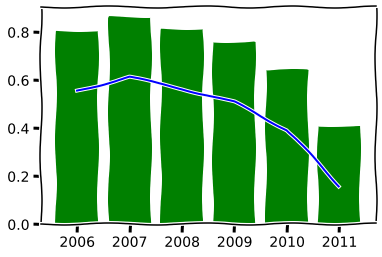

In [86]:
plt.bar(years, ie_users, color='g')
plt.plot(years, murder_num, c='b')

plt.show()

In [88]:
st.pearsonr(years, ie_users)[0], st.pearsonr(comp_num, ie_users)[0]

(-0.861487246095062, -0.9982211910256553)

In [89]:
st.spearmanr(years, ie_users)[0], st.spearmanr(comp_num, ie_users)[0]

(-0.8285714285714287, -1.0)

In [90]:
r12 = st.pearsonr(ie_users, murder_num)[0]
r13 = st.pearsonr(murder_num, comp_num)[0]
r23 = st.pearsonr(ie_users, comp_num)[0]

r12, r13, r23

(1.0, -0.9982211910256553, -0.9982211910256553)

#### Условная корреляция
$$r_{1,2|3} = \frac{r_{1, 2} - r_{1, 3}*r_{2, 3}}{\sqrt[]{(1-r_{1, 3}^2)(1-r_{2, 3}^2)}}$$

In [91]:
r = (r12 - r13*r23) / np.sqrt((1-r13**2)*(1-r23**2))
r

1.0

Условная вероятность помогает более качественно оценить зависимость путем добавления третьей переменной.

### Вариант 3
Пусть процент убийств снижается с процентом взрослого населения в стране.
Доля IE возрастает.


In [94]:
rs = np.random.RandomState(0)
adult = np.array([32,35,  38, 38, 39, 39])
murder_num = -0.6/10**9 *  comp_num + 0.3 + rs.uniform(size=years.shape[0])*0.1 + adult/40
murder_num


array([0.50662055, 0.63703503, 0.66488189, 0.60764987, 0.5184386 ,
       0.28532603])

In [95]:
rs = np.random.RandomState(0)
ie_users =  -0.6/10**9 *  comp_num+2.2 + rs.uniform(size=years.shape[0])*0.1 - adult/40
ie_users 


array([0.80662055, 0.78703503, 0.66488189, 0.60764987, 0.4684386 ,
       0.23532603])

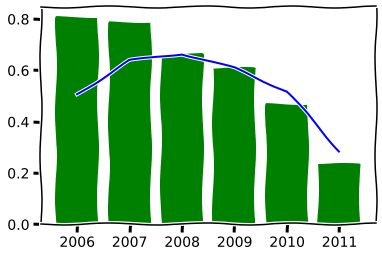

In [96]:
plt.bar(years, ie_users, color='g')
plt.plot(years, murder_num, c='b')

plt.show()

In [97]:
r12 = st.pearsonr(ie_users, murder_num)[0]
r13 = st.pearsonr(murder_num, comp_num)[0]
r23 = st.pearsonr(ie_users, comp_num)[0]

r12, r13, r23

(0.7738271741358052, -0.916089942643887, -0.9601569943820956)

#### Условная корреляция
$$r_{1,2|3} = \frac{r_{1, 2} - r_{1, 3}*r_{2, 3}}{\sqrt[]{(1-r_{1, 3}^2)(1-r_{2, 3}^2)}}$$

In [98]:
r = (r12 - r13*r23) / np.sqrt((1-r13**2)*(1-r23**2))
r

-0.9438376514862333

In [99]:
r14 = st.pearsonr(murder_num, adult)[0]
r24 = st.pearsonr(ie_users, adult)[0]

r14, r24

(-0.2022666855201769, -0.7768242481877352)

In [100]:
r = (r12 - r14*r24) / np.sqrt((1-r14**2)*(1-r24**2))
r

0.9999999999999994

#### Условная корреляция через матрицу
$$r_{i,j}|other= \frac{r_{i,j}}{r_{ii}, r_{jj}}$$

##### Pearson

In [106]:
matrix = np.zeros((4,4))
datasets = [ie_users, murder_num, comp_num, adult]
for i in range(4):
    for j in range(i,4):
        matrix[i,j] = st.pearsonr(datasets[i], datasets[j])[0] / st.pearsonr(datasets[i], datasets[i])[0]*st.pearsonr(datasets[j], datasets[j])[0]
matrix

array([[ 1.        ,  0.77382717, -0.96015699, -0.77682425],
       [ 0.        ,  1.        , -0.91608994, -0.20226669],
       [ 0.        ,  0.        ,  1.        ,  0.57378435],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [107]:
R = np.linalg.inv(matrix)
R

array([[ 1.        , -0.77382717,  0.2512617 ,  0.47613476],
       [ 0.        ,  1.        ,  0.91608994, -0.32337139],
       [ 0.        ,  0.        ,  1.        , -0.57378435],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])